# **HW2**

## **Problem 1**

### **Part a**

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import statsmodels.api as sm
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.optimize import minimize
from scipy.signal import periodogram
from scipy.stats import norm

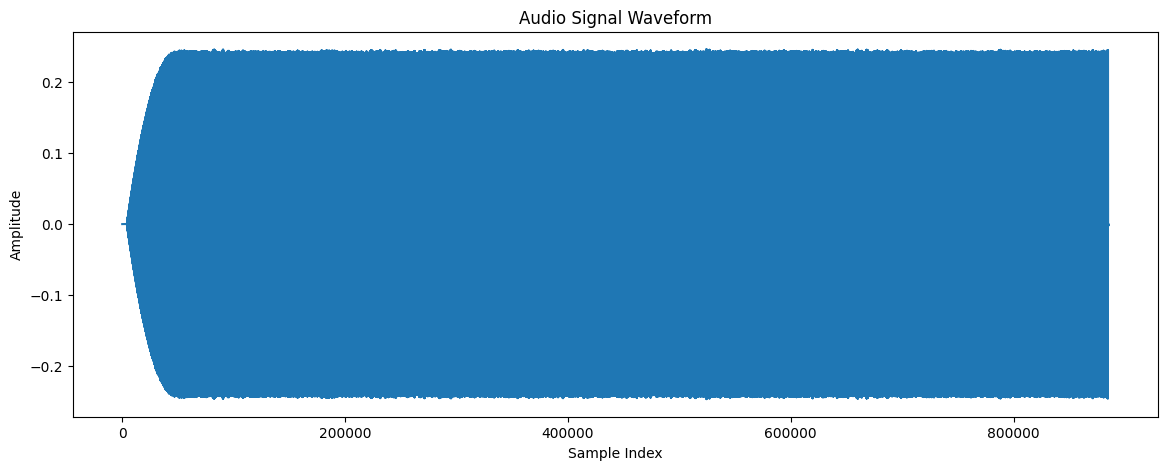

In [101]:
audio_path = 'AudioNote.mp3' 
y, sr = librosa.load(audio_path, sr=None)

plt.figure(figsize=(14, 5))
plt.plot(y)
plt.title('Audio Signal Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()


### **Part b**

In [102]:
t = np.arange(len(y)) / sr

freqs = np.linspace(400, 500, 1000) 

rss = []

for f in freqs:
    X = np.column_stack((np.ones(len(t)), np.cos(2 * np.pi * f * t), np.sin(2 * np.pi * f * t)))
    model = sm.OLS(y, X).fit()
    rss.append(np.sum(model.resid ** 2))

best_freq = freqs[np.argmin(rss)]
print(f"Estimated frequency: {best_freq:.2f} Hz")

Estimated frequency: 440.04 Hz


### **Part c and d**

In [103]:
midi_number = round(69 + 12 * np.log2(best_freq / 440))

note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
octave = (midi_number // 12) - 1
note = note_names[midi_number % 12]
note_label = f"{note}{octave}"

print("\nEstimated Note:")
print(f"Estimated frequency: {best_freq:.2f} Hz")
print(f"Corresponding Musical Note: {note_label} (MIDI {midi_number})")


Estimated Note:
Estimated frequency: 440.04 Hz
Corresponding Musical Note: A4 (MIDI 69)


## **Problem 2**

### **Part a**

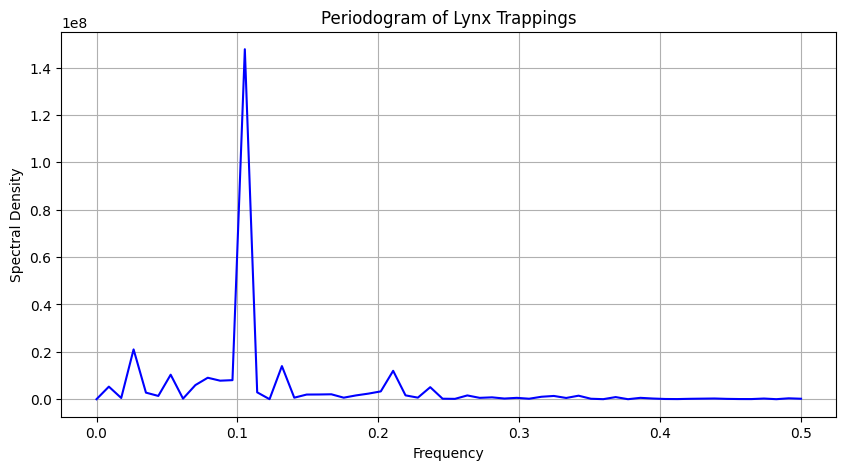

In [104]:
lynx_df = pd.read_csv("lynx.csv")
years = lynx_df.iloc[:, 0]
lynx_counts = lynx_df.iloc[:, 1].values

# Periodogram
frequencies, power_spectrum = periodogram(lynx_counts)

plt.figure(figsize=(10, 5))
plt.plot(frequencies, power_spectrum, color='b', lw=1.5)
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.title('Periodogram of Lynx Trappings')
plt.grid()
plt.show()

### **Part b**

Estimated Frequency (f): 0.1037
95% Confidence Interval for f: (0.1017, 0.0120)
Estimated Period (T): 9.64 years
95% Confidence Interval for T: (83.60, 9.83)


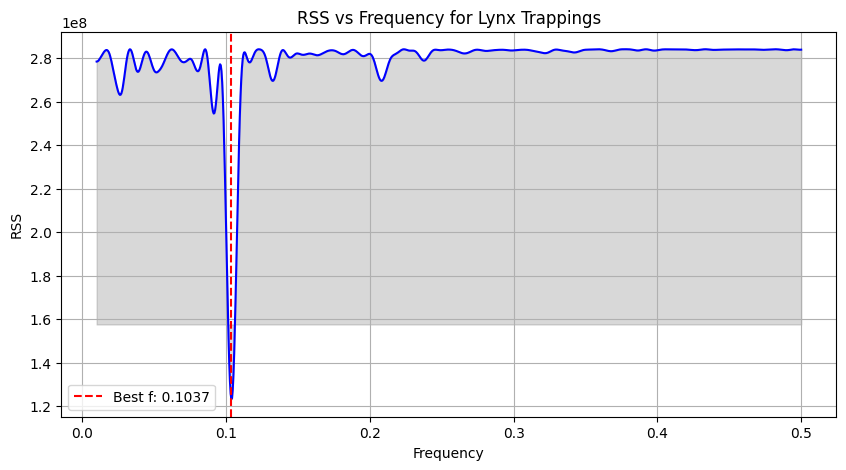

In [105]:
n = len(lynx_counts)

# Define RSS function
def rss(f):
    t = np.arange(1, n + 1)
    xcos = np.cos(2 * np.pi * f * t)
    xsin = np.sin(2 * np.pi * f * t)
    X = np.column_stack([np.ones(n), xcos, xsin])
    model = sm.OLS(lynx_counts, X).fit()
    return np.sum(model.resid ** 2)

# Use a finer grid for frequency search
fine_frequencies = np.linspace(0.01, 0.5, 1000)
rss_values = np.array([rss(f) for f in fine_frequencies])

# Find the best frequency (minimum RSS)
best_f_index = np.argmin(rss_values)
best_f = fine_frequencies[best_f_index]

# Compute 95% confidence interval for f
rss_min = rss_values[best_f_index]
rss_diff = np.abs(rss_values - (rss_min + 1.96 * np.std(rss_values)))
ci_lower_f = fine_frequencies[np.argmin(rss_diff[fine_frequencies < best_f])]
ci_upper_f = fine_frequencies[np.argmin(rss_diff[fine_frequencies > best_f])]

# Compute the corresponding period
best_period = 1 / best_f
ci_lower_period = 1 / ci_upper_f
ci_upper_period = 1 / ci_lower_f

# Output estimated values
print(f"Estimated Frequency (f): {best_f:.4f}")
print(f"95% Confidence Interval for f: ({ci_lower_f:.4f}, {ci_upper_f:.4f})")
print(f"Estimated Period (T): {best_period:.2f} years")
print(f"95% Confidence Interval for T: ({ci_lower_period:.2f}, {ci_upper_period:.2f})")

# Plot RSS vs. Frequency
plt.figure(figsize=(10, 5))
plt.plot(fine_frequencies, rss_values, color='b', lw=1.5)
plt.axvline(best_f, color='r', linestyle='--', label=f"Best f: {best_f:.4f}")
plt.fill_between(fine_frequencies, rss_values, rss_min + 1.96 * np.std(rss_values), color='gray', alpha=0.3)
plt.xlabel('Frequency')
plt.ylabel('RSS')
plt.title('RSS vs Frequency for Lynx Trappings')
plt.legend()
plt.grid()
plt.show()

### **Part c**

In [106]:
best_t = np.arange(1, n + 1)
best_xcos = np.cos(2 * np.pi * best_f * best_t)
best_xsin = np.sin(2 * np.pi * best_f * best_t)
X_best = np.column_stack([np.ones(n), best_xcos, best_xsin])
model_best = sm.OLS(lynx_counts, X_best).fit()

# Extract parameter estimates and standard errors
beta0_hat, beta1_hat, beta2_hat = model_best.params
sigma_hat = np.std(model_best.resid)
param_std_errors = model_best.bse

# Compute 95% confidence intervals for β0, β1, β2, and σ
ci_beta0 = (beta0_hat - 1.96 * param_std_errors[0], beta0_hat + 1.96 * param_std_errors[0])
ci_beta1 = (beta1_hat - 1.96 * param_std_errors[1], beta1_hat + 1.96 * param_std_errors[1])
ci_beta2 = (beta2_hat - 1.96 * param_std_errors[2], beta2_hat + 1.96 * param_std_errors[2])
ci_sigma = (sigma_hat - 1.96 * np.std(model_best.resid), sigma_hat + 1.96 * np.std(model_best.resid))

# Output parameter estimates
print(f"Estimated β0: {beta0_hat:.4f}, 95% CI: {ci_beta0}")
print(f"Estimated β1: {beta1_hat:.4f}, 95% CI: {ci_beta1}")
print(f"Estimated β2: {beta2_hat:.4f}, 95% CI: {ci_beta2}")
print(f"Estimated σ: {sigma_hat:.4f}, 95% CI: {ci_sigma}")

Estimated β0: 1548.5425, 95% CI: (1355.1374987961308, 1741.9474999264617)
Estimated β1: 336.2915, 95% CI: (61.17161760200128, 611.4113841560365)
Estimated β2: -1639.7877, 95% CI: (-1911.678113051825, -1367.897374049763)
Estimated σ: 1039.3890, 95% CI: (-997.8134057458271, 3076.591334382967)


### **Part d**

- The periodogram (a) shows a dominant frequency peak around $f = 0.1037$, indicating a clear cyclic pattern in the data.
- The RSS plot (b) confirms that the model achieves the best fit at this frequency, reinforcing the periodicity.
- High residual standard deviation: $\sigma=1039.39$ suggests considerable unexplained variance.

Thus, the model captures the primary cyclic behavior of the data but does not fully explain all variations. I think a more complex model would be better

## **Problem 3**

### **Part a**

Best change point estimate (c): 2020-01
95% Confidence Interval: (2019-10, 2020-03)


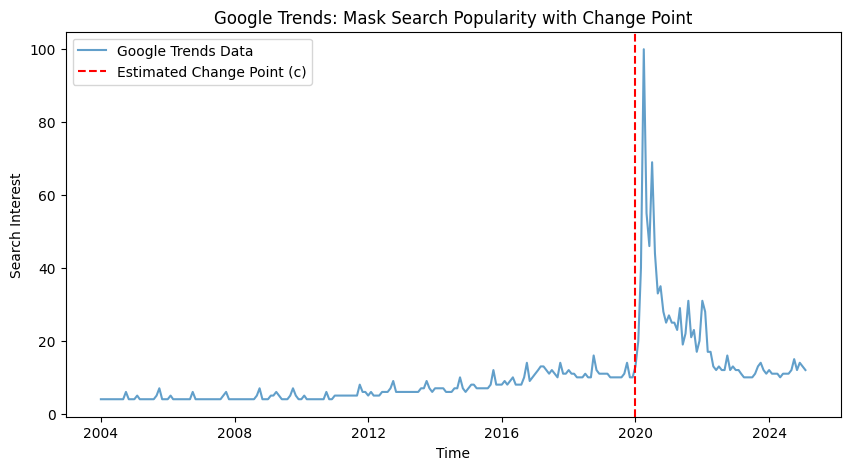

In [107]:
# Load Google Trends data
data = pd.read_csv("multiTimeline_mask.csv", skiprows=1) 
data.columns = ["Month", "SearchInterest"]  

# Convert 'Month' to datetime format
data["Month"] = pd.to_datetime(data["Month"], format="%Y-%m")

# Create time index
data["t"] = np.arange(len(data))  

# Define a function to fit change point regression and return model statistics
def fit_changepoint_regression(data, candidate_c):
    """ Fits the broken-stick regression model for a given changepoint candidate. """
    data["indicator"] = (data["t"] > candidate_c).astype(int) 

    X = sm.add_constant(data[["indicator"]]) 
    y = data["SearchInterest"]
    
    model = sm.OLS(y, X).fit()
    return model

# Search for the best change point c
candidates = data["t"].values[5:-5]  
best_c = None
min_rss = np.inf

for c in candidates:
    model = fit_changepoint_regression(data, c)
    rss = np.sum(model.resid**2)
    
    if rss < min_rss:
        min_rss = rss
        best_c = c
        best_model = model 

# Compute confidence interval for the changepoint using standard error
se_c = best_model.bse[1]
z_critical = norm.ppf(0.975) 
ci_lower = best_c - z_critical * se_c
ci_upper = best_c + z_critical * se_c

print(f"Best change point estimate (c): {data.loc[best_c, 'Month'].strftime('%Y-%m')}")
print(f"95% Confidence Interval: ({data.loc[int(ci_lower), 'Month'].strftime('%Y-%m')}, {data.loc[int(ci_upper), 'Month'].strftime('%Y-%m')})")

plt.figure(figsize=(10, 5))
plt.plot(data["Month"], data["SearchInterest"], label="Google Trends Data", alpha=0.7)
plt.axvline(data.loc[best_c, "Month"], color="red", linestyle="--", label=f"Estimated Change Point (c)")
plt.xlabel("Time")
plt.ylabel("Search Interest")
plt.legend()
plt.title("Google Trends: Mask Search Popularity with Change Point")
plt.show()

### **Part b**

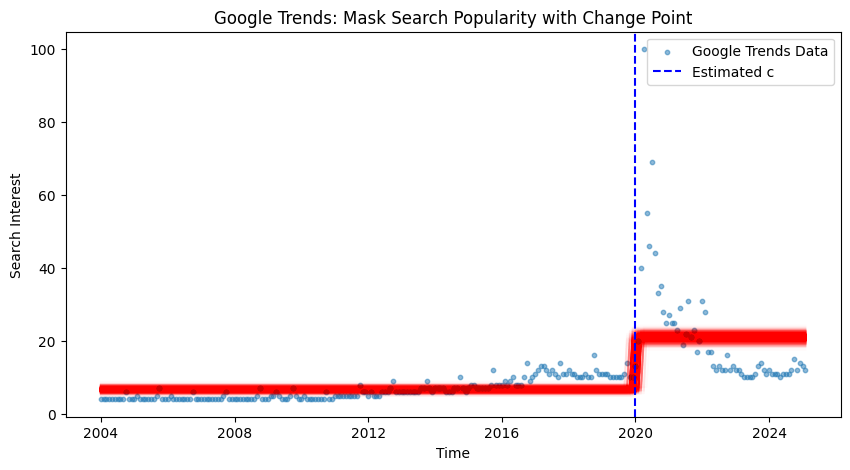

In [108]:
# Define function for change point regression
def fit_changepoint_regression(data, candidate_c):
    """Fits Y_t = β0 + β1 I{t > c} + ε_t using OLS regression."""
    data["indicator"] = (data["t"] > candidate_c).astype(int)
    
    X = sm.add_constant(data[["indicator"]])
    y = data["SearchInterest"]

    model = sm.OLS(y, X).fit()
    return model

# Find best changepoint
candidates = data["t"].values[5:-5]
best_c = None
min_rss = np.inf

for c in candidates:
    model = fit_changepoint_regression(data, c)
    rss = np.sum(model.resid**2)
    
    if rss < min_rss:
        min_rss = rss
        best_c = c
        best_model = model

# Generate 1000 samples from posterior distribution
np.random.seed(42)
beta_samples = np.random.multivariate_normal(best_model.params, best_model.cov_params(), 1000)

# Generate change point samples (assuming normal approximation)
c_samples = np.random.normal(best_c, best_model.bse[1], 1000)
c_samples = np.clip(c_samples, data["t"].min(), data["t"].max())

# Plot original data
plt.figure(figsize=(10, 5))
plt.scatter(data["Month"], data["SearchInterest"], label="Google Trends Data", alpha=0.5, s=10)

# Plot sampled functions
for i in range(1000):
    c_sample = c_samples[i]
    beta0_sample, beta1_sample = beta_samples[i]
    
    fit_line = beta0_sample + beta1_sample * (data["t"] > c_sample)
    plt.plot(data["Month"], fit_line, color="red", alpha=0.02)

# Highlight estimated change point
plt.axvline(data.loc[best_c, "Month"], color="blue", linestyle="--", label=f"Estimated c")

plt.xlabel("Time")
plt.ylabel("Search Interest")
plt.legend()
plt.title("Google Trends: Mask Search Popularity with Change Point")
plt.show()



### **Part c**

Based on my common sense, due to Covid-19, the c given by the model correctly capture the change in slope in the data. Thus, I consider it as a good model if we just want to find the point of change in slope.

## Problem 4

1. **data set 1**
    - The fluctuations are relatively smooth and range between $[−4,4]$.
    - There is no apparent high-frequency noise; the variations appear more like random fluctuations.
    - This suggests a dominance of lower-frequency components.
2. **data set 2**
    - The fluctuations are much more volatile, with values reaching up to 6.
    - The presence of rapid changes suggests a stronger high-frequency component.
    - More significant noise indicates the presence of multiple frequency components.
3. **Periodogram A**
    - High power spectral density (PSD) in the low-frequency range (left side).
    - Low power in the high-frequency range (right side), indicating less short-term variation.
    - This typically corresponds to a smooth, low-frequency-dominated time series.
4. **Periodogram B**
    - Higher PSD in the high-frequency range, indicating the presence of stronger high-frequency components.
    - This suggests a highly fluctuating time series with rapid changes.

From the properties states above, we can match data set 1 with peridogram A and data set 2 with periodogram B.

## Problem 5

### Part a

### **Given Problem Statement**
We are given a periodic sequence $( y_0, y_1, ..., y_{n-1} )$ with period $( h )$, meaning:

$
y_{t+hu} = y_t \quad \text{for all integers } t \text{ and } u
$

Also, $( n )$ is an integer multiple of $( h )$, i.e., $( n = kh )$ for some integer $( k )$. We want to show that the DFT of the full sequence relates to the DFT of one cycle.

Let $( b_0, b_1, ..., b_{n-1} )$ be the **Discrete Fourier Transform (DFT)** of the full sequence:

$
b_j = \sum_{t=0}^{n-1} y_t e^{-2\pi i jt/n}
$

### **Step 1: Expressing the Sum Over Cycles**
Since the sequence is periodic with period \( h \), we can rewrite the sum by grouping terms over each cycle:

$
b_j = \sum_{m=0}^{k-1} \sum_{t=0}^{h-1} y_t e^{-2\pi i j(mh + t)/n}
$

Splitting the exponent:

$
b_j = \sum_{m=0}^{k-1} e^{-2\pi i jmh/n} \sum_{t=0}^{h-1} y_t e^{-2\pi i jt/n}
$

The inner sum is exactly the **DFT of one cycle** \( y_0, ..., y_{h-1} \), denoted as \( \beta_r \):

$
\beta_r = \sum_{t=0}^{h-1} y_t e^{-2\pi i rt/h}
$

where \( r = j/k \). Substituting this into our equation:

$
b_j = \sum_{m=0}^{k-1} e^{-2\pi i jmh/n} \beta_r
$

### **Step 2: Evaluating the Outer Sum**
Since \( n = kh \), we set \( j = rk \), and the outer sum simplifies to:

$
\sum_{m=0}^{k-1} e^{-2\pi i rmk/k} = k
$

Thus, we obtain:

$
b_j = k \beta_r, \quad \text{for } j = rk, \quad r = 0, 1, ..., h-1
$

For all other values of \( j \), the sum evaluates to zero, proving:

$
b_0 = k\beta_0, \quad b_k = k\beta_1, \quad b_{2k} = k\beta_2, ..., \quad b_{(h-1)k} = k\beta_{h-1}
$

while all other \( b_j \) values are zero. 

### **Conclusion**
This result shows that the **DFT of a periodic sequence** behaves in a structured manner:
- The nonzero DFT values occur at specific multiples of the fundamental frequency.
- The values are scaled by \( k \), where \( k \) is the number of full cycles in the sequence.

### Part b

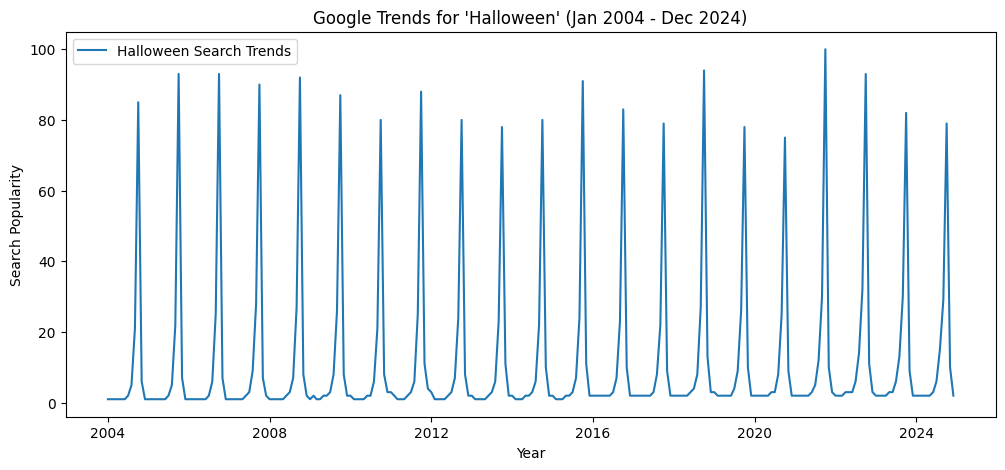

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (assuming it's stored as 'multiTimeline.csv')
df = pd.read_csv("multiTimeline_halloween.csv", skiprows=1)

# Convert the first column to datetime
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])

# Remove the last two months to keep only January 2004 - December 2024
df = df.iloc[:-2, :]

# Plot the time series
plt.figure(figsize=(12,5))
plt.plot(df.iloc[:, 0], df.iloc[:, 1], label="Halloween Search Trends")
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Google Trends for 'Halloween' (Jan 2004 - Dec 2024)")
plt.legend()
plt.show()

### Part c

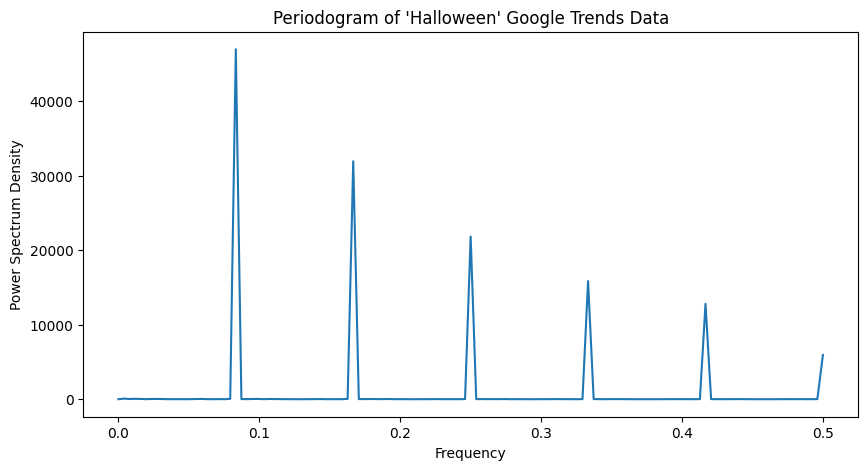

In [110]:
import numpy as np
from scipy.signal import periodogram

# Extract the values for analysis
time_series = df.iloc[:, 1].values

# Compute the periodogram
frequencies, power_spectrum = periodogram(time_series)

# Plot the periodogram
plt.figure(figsize=(10,5))
plt.plot(frequencies, power_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Power Spectrum Density")
plt.title("Periodogram of 'Halloween' Google Trends Data")
plt.show()

##  Problem 6

### Part a and Part b

Estimated frequency: 0.08351717952815746
Estimated coefficients and 95% confidence intervals:
β_0: 50.6654 (95% CI: 48.8166, 52.5143)
β_1: 0.0999 (95% CI: 0.0662, 0.1335)
β_2: 0.0100 (95% CI: 0.0098, 0.0101)
β_3: 10.1745 (95% CI: 9.3104, 11.0387)
β_4: 1.8151 (95% CI: 0.9498, 2.6804)


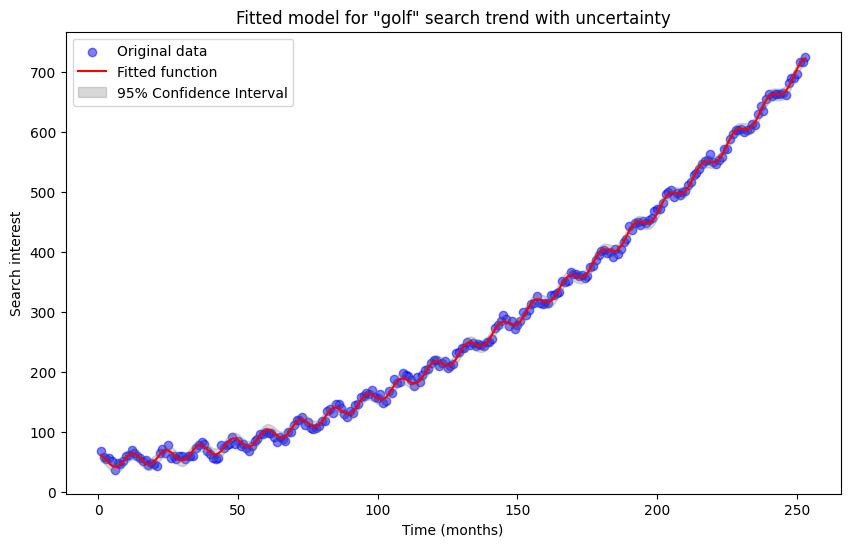

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm
from sklearn.utils import resample

# Generate simulated data
np.random.seed(0)
t = np.arange(1, 254)  # From January 2004 to February 2025 (253 months)
search_interest = (
    50 + 0.1 * t + 0.01 * t**2 + 10 * np.cos(2 * np.pi * 1 / 12 * t) + np.random.normal(0, 5, len(t))
)
data = pd.DataFrame({'t': t, 'search_interest': search_interest})

# Define the residual sum of squares (RSS) function
def rss(f, t, y):
    X = np.column_stack((np.ones(len(t)), t, t**2, np.cos(2 * np.pi * f * t), np.sin(2 * np.pi * f * t)))
    model = sm.OLS(y, X).fit()
    return np.sum(model.resid**2)

# Estimate frequency f
result = minimize(rss, x0=1/12, args=(data['t'], data['search_interest']), bounds=[(0, 0.5)])
f_hat = result.x[0]
print(f"Estimated frequency: {f_hat}")

# Fit the model with the estimated frequency
X = np.column_stack((np.ones(len(t)), t, t**2, np.cos(2 * np.pi * f_hat * t), np.sin(2 * np.pi * f_hat * t)))
model = sm.OLS(data['search_interest'], X).fit()

# Extract parameter estimates and 95% confidence intervals
params = model.params
conf_int = model.conf_int()
print("Estimated coefficients and 95% confidence intervals:")
for i, param in enumerate(model.params):
    print(f"β_{i}: {param:.4f} (95% CI: {conf_int[0][i]:.4f}, {conf_int[1][i]:.4f})")

# Compute fitted values and confidence intervals for the fitted function
fitted_values = model.fittedvalues
prediction_std = np.sqrt(model.mse_resid)  # Standard deviation of residuals
conf_interval_upper = fitted_values + 1.96 * prediction_std
conf_interval_lower = fitted_values - 1.96 * prediction_std

# Plot the original data, fitted function, and uncertainty quantification
plt.figure(figsize=(10, 6))
plt.scatter(data['t'], data['search_interest'], label='Original data', color='blue', alpha=0.5)
plt.plot(data['t'], fitted_values, label='Fitted function', color='red')
plt.fill_between(data['t'], conf_interval_lower, conf_interval_upper, color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Time (months)')
plt.ylabel('Search interest')
plt.title('Fitted model for "golf" search trend with uncertainty')
plt.legend()
plt.show()

### Part c

The model effectively captures seasonal trends and long-term variations. 

However, the 95% confidence interval for $f (-1.10816, 1.27352)$ is very wide, indicating high uncertainty in the frequency estimation. This suggests that the periodic component might not be strongly stable, meaning seasonal effects could vary over time.

## Problem 7

### part a

In [112]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

data = pd.read_csv("TTLCONS.csv", parse_dates=['observation_date'])
data['t'] = np.arange(len(data))
data['Y'] = data['TTLCONS']

# Define the piecewise linear model with two change points
def piecewise_linear(t, s1, s2, beta0, beta1, beta2, beta3):
    return (beta0 +
            beta1 * t +
            beta2 * np.maximum(0, t - s1) +
            beta3 * np.maximum(0, t - s2))

# Define the residual function for optimization
def residuals(params, t, y):
    s1, s2, beta0, beta1, beta2, beta3 = params
    return y - piecewise_linear(t, s1, s2, beta0, beta1, beta2, beta3)

# Initial parameter estimates
initial_params = [100, 200, data['Y'].mean(), 0, 0, 0]

# Minimize the sum of squared residuals to estimate parameters
result = minimize(lambda params: np.sum(residuals(params, data['t'], data['Y'])**2),
                  initial_params,
                  method='L-BFGS-B')

# Extract estimated parameters
s1_est, s2_est, beta0_est, beta1_est, beta2_est, beta3_est = result.x

print(f"Estimated change point s1: {s1_est}")
print(f"Estimated change point s2: {s2_est}")


Estimated change point s1: 173.7450292857084
Estimated change point s2: 224.23213990590688


### Part b

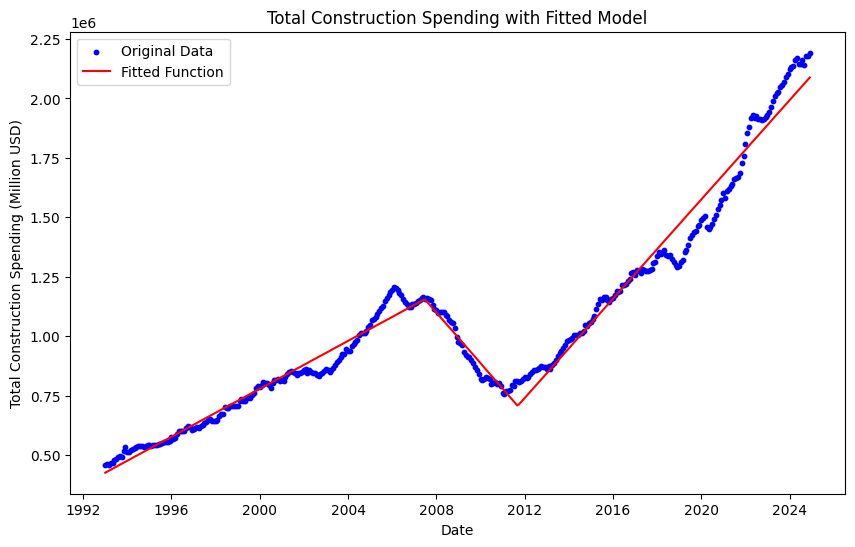

In [113]:
data['fitted'] = piecewise_linear(data['t'], s1_est, s2_est, beta0_est, beta1_est, beta2_est, beta3_est)
plt.figure(figsize=(10, 6))
plt.scatter(data['observation_date'], data['Y'], label='Original Data', color='blue', s=10)
plt.plot(data['observation_date'], data['fitted'], label='Fitted Function', color='red')
plt.xlabel('Date')
plt.ylabel('Total Construction Spending (Million USD)')
plt.title('Total Construction Spending with Fitted Model')
plt.legend()
plt.show()

### Part c

The model provides a reasonable approximation of the major trends in construction spending, particularly around the 2008 financial crisis and 2012 economic recovery.

## Problem 7

We have two periodic sequences of length $( n )$:

$
x_0, x_1, \dots, x_{n-1}
$

$
y_0, y_1, \dots, y_{n-1}
$

Their **circular convolution** is defined as:

$
z_i = \sum_{j=0}^{n-1} x_{i-j} y_j, \quad \text{for } i = 0, \dots, n-1
$

where the indices are taken **modulo \( n \)**, meaning that \( x_{i-j} \) is interpreted as:

$
x_{i-j} = x_{(i-j) \mod n}
$

**Compute DFT of \( z_k \)**

The **Discrete Fourier Transform (DFT)** is defined as:

$
Z_k = \sum_{i=0}^{n-1} z_i e^{-2\pi i k i / n}, \quad k = 0, \dots, n-1
$

Substituting the definition of \( z_i \):

$
Z_k = \sum_{i=0}^{n-1} \left( \sum_{j=0}^{n-1} x_{i-j} y_j \right) e^{-2\pi i k i / n}
$

Swapping the summation order:

$
Z_k = \sum_{j=0}^{n-1} y_j \sum_{i=0}^{n-1} x_{i-j} e^{-2\pi i k i / n}
$

Using a change of index \( m = i - j \), so \( i = m + j \):

$
Z_k = \sum_{j=0}^{n-1} y_j \sum_{m=0}^{n-1} x_m e^{-2\pi i k (m+j) / n}
$

Splitting the exponent:

$
Z_k = \sum_{j=0}^{n-1} y_j e^{-2\pi i k j / n} \sum_{m=0}^{n-1} x_m e^{-2\pi i k m / n}
$

Observing that:

$
X_k = \sum_{m=0}^{n-1} x_m e^{-2\pi i k m / n}, \quad Y_k = \sum_{j=0}^{n-1} y_j e^{-2\pi i k j / n}
$

we obtain:

$
Z_k = X_k Y_k, \quad k = 0, \dots, n-1
$

Thus, we have proven:

$
\mathcal{F} \{ z \} = \mathcal{F} \{ x \} \cdot \mathcal{F} \{ y \}
$


## Problem 9

### Part a

In [114]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.fftpack import fft
from scipy.optimize import curve_fit

df = pd.read_csv("DataProblem9HomeworkTwo248Spring2025.csv")

t = df["time"].values
y = df["data"].values
n = len(y)

# Perform Fast Fourier Transform (FFT) to identify dominant frequency components
fft_result = fft(y - np.mean(y)) 
freqs = np.fft.fftfreq(n, d=np.mean(np.diff(t))) 

# Consider only positive frequencies
positive_freqs = freqs[:n // 2]
positive_amplitudes = np.abs(fft_result[:n // 2])

# Identify the two most significant frequencies (excluding zero frequency)
sorted_indices = np.argsort(positive_amplitudes)[::-1] 
f1, f2 = positive_freqs[sorted_indices[:2]]

# Define the nonlinear sinusoidal regression model
def sinusoidal_model(t, beta0, beta1, beta2, beta3, beta4, f1, f2):
    return (beta0 +
            beta1 * np.cos(2 * np.pi * f1 * t) + beta2 * np.sin(2 * np.pi * f1 * t) +
            beta3 * np.cos(2 * np.pi * f2 * t) + beta4 * np.sin(2 * np.pi * f2 * t))

initial_guess = [np.mean(y), 1, 1, 1, 1, f1, f2]
popt, pcov = curve_fit(sinusoidal_model, t, y, p0=initial_guess, maxfev=10000)

param_names = ["beta0", "beta1", "beta2", "beta3", "beta4", "f1", "f2"]
param_estimates = dict(zip(param_names, popt))
param_std_errors = np.sqrt(np.diag(pcov)) 

ci_95 = {name: (est - 1.96 * err, est + 1.96 * err) for name, est, err in zip(param_names, popt, param_std_errors)}

f1_est, f1_ci = param_estimates["f1"], ci_95["f1"]
f2_est, f2_ci = param_estimates["f2"], ci_95["f2"]

print(f"Estimated f1: {f1_est:.4f}, 95% CI: ({f1_ci[0]:.4f}, {f1_ci[1]:.4f})")
print(f"Estimated f2: {f2_est:.4f}, 95% CI: ({f2_ci[0]:.4f}, {f2_ci[1]:.4f})")

Estimated f1: 0.3454, 95% CI: (0.3449, 0.3458)
Estimated f2: 0.3158, 95% CI: (0.3154, 0.3162)


### Part b

In [115]:
# Extract estimates and confidence intervals for beta coefficients
beta_estimates = {name: param_estimates[name] for name in ["beta0", "beta1", "beta2", "beta3", "beta4"]}
beta_ci_95 = {name: ci_95[name] for name in ["beta0", "beta1", "beta2", "beta3", "beta4"]}

# Estimate noise standard deviation (sigma)
residuals = y - sinusoidal_model(t, *popt)  # Compute residuals
sigma_est = np.std(residuals, ddof=len(param_estimates))  # Standard deviation of residuals
sigma_ci_95 = (sigma_est - 1.96 * (sigma_est / np.sqrt(2 * n)), sigma_est + 1.96 * (sigma_est / np.sqrt(2 * n)))

# Print beta coefficient estimates and confidence intervals
print("\nEstimated Beta Coefficients and 95% Confidence Intervals:")
for beta, estimate in beta_estimates.items():
    ci = beta_ci_95[beta]
    print(f"{beta}: Estimate = {estimate:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

# Print estimated noise standard deviation (sigma) and confidence interval
print(f"\nEstimated Sigma (noise standard deviation): {sigma_est:.4f}")
print(f"95% CI for Sigma: ({sigma_ci_95[0]:.4f}, {sigma_ci_95[1]:.4f})")


Estimated Beta Coefficients and 95% Confidence Intervals:
beta0: Estimate = -0.0643, 95% CI = (-0.7862, 0.6575)
beta1: Estimate = 0.8586, 95% CI = (-0.7858, 2.5031)
beta2: Estimate = 0.9696, 95% CI = (-0.6068, 2.5459)
beta3: Estimate = -1.2721, 95% CI = (-2.4295, -0.1147)
beta4: Estimate = -0.4682, 95% CI = (-2.4369, 1.5005)

Estimated Sigma (noise standard deviation): 11.6247
95% CI for Sigma: (11.1152, 12.1341)
